In [25]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

In [15]:
df_cleaned = pd.read_csv(
    "../Data/CleanedData.csv").drop(columns=["Unnamed: 0"])

In [16]:
df_cleaned

,Open,High,Low,Close,Volume,CPI,Unemployment Rate,Fed Funds Rate,M2 Money Supply,Close_lag_1,Close_lag_2,Close_lag_3,5_day_ma,20_day_ma,day_diff
0,86.558580,89.018310,86.040742,88.948601,10768700.0,169.300,4.0,5.45,4667.6,86.598404,89.386726,89.745270,89.028246,90.988057,2.390021
1,89.068073,90.302917,88.291317,89.824913,8419900.0,170.000,4.1,5.73,4680.9,88.948601,86.598404,89.386726,88.900783,90.844656,0.756840
2,90.044005,90.661426,89.466416,89.904587,6205900.0,170.000,4.1,5.73,4680.9,89.824913,88.948601,86.598404,88.932646,90.886481,-0.139418
3,89.785051,91.298730,89.227380,91.258896,7997500.0,170.000,4.1,5.73,4680.9,89.904587,89.824913,88.948601,89.307080,90.988055,1.473845
4,91.258928,91.776766,90.581756,90.880508,4925400.0,170.000,4.1,5.73,4680.9,91.258896,89.904587,89.824913,90.163501,91.142411,-0.378420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6285,594.809998,599.690002,594.640015,599.369995,70361100.0,317.685,4.1,4.48,21533.8,607.969971,609.750000,606.440002,605.315991,593.668503,4.559998
6286,600.619995,605.369995,597.250000,604.520020,44433300.0,317.685,4.1,4.48,21533.8,599.369995,607.969971,609.750000,605.609998,593.827502,3.900024
6287,603.719971,604.130005,599.219971,601.809998,37177400.0,317.685,4.1,4.48,21533.8,604.520020,599.369995,607.969971,604.683997,594.167502,-1.909973
6288,603.960022,606.599976,600.719971,605.039978,39281300.0,317.685,4.1,4.48,21533.8,601.809998,604.520020,599.369995,603.741992,595.008502,1.079956


In [17]:
X = df_cleaned.drop(columns=['day_diff'])
y = df_cleaned['day_diff']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu',
                          kernel_regularizer=regularizers.l2(0.01),
                          input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu',
                          kernel_regularizer=regularizers.l2(0.005)),
    Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae'])

/Users/andrew/Desktop/Projects/MarketPredictor/env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2772 - mae: 0.8870 - val_loss: 13.0761 - val_mae: 2.6247 - learning_rate: 0.0010
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9636 - mae: 0.7815 - val_loss: 13.0858 - val_mae: 2.6371 - learning_rate: 0.0010
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7662 - mae: 0.7491 - val_loss: 13.0732 - val_mae: 2.6341 - learning_rate: 0.0010
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6755 - mae: 0.7135 - val_loss: 13.0008 - val_mae: 2.6096 - learning_rate: 0.0010
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6324 - mae: 0.7267 - val_loss: 12.9327 - val_mae: 2.6415 - learning_rate: 0.0010
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5870 - mae: 0.7267 - val_loss: 12.9673 - val_mae: 2.6516 - learning_rate: 0.0010
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6007 - mae: 0.7344 - val_loss: 13.5159 - val_mae: 2.7584 - learning_rate: 0.0010
Epoch 

In [20]:
train_pred = model.predict(X_train_scaled)
test_pred = model.predict(X_test_scaled)

print("\nTraining Evaluation:")
print(f"MAE: {mean_absolute_error(y_train, train_pred):.4f}")
print(f"R²: {r2_score(y_train, train_pred):.4f}")

print("\nTest Evaluation:")
print(f"MAE: {mean_absolute_error(y_test, test_pred):.4f}")
print(f"R²: {r2_score(y_test, test_pred):.4f}")

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step

Training Evaluation:
MAE: 0.6875
R²: 0.1070

Test Evaluation:
MAE: 2.5233
R²: 0.0695


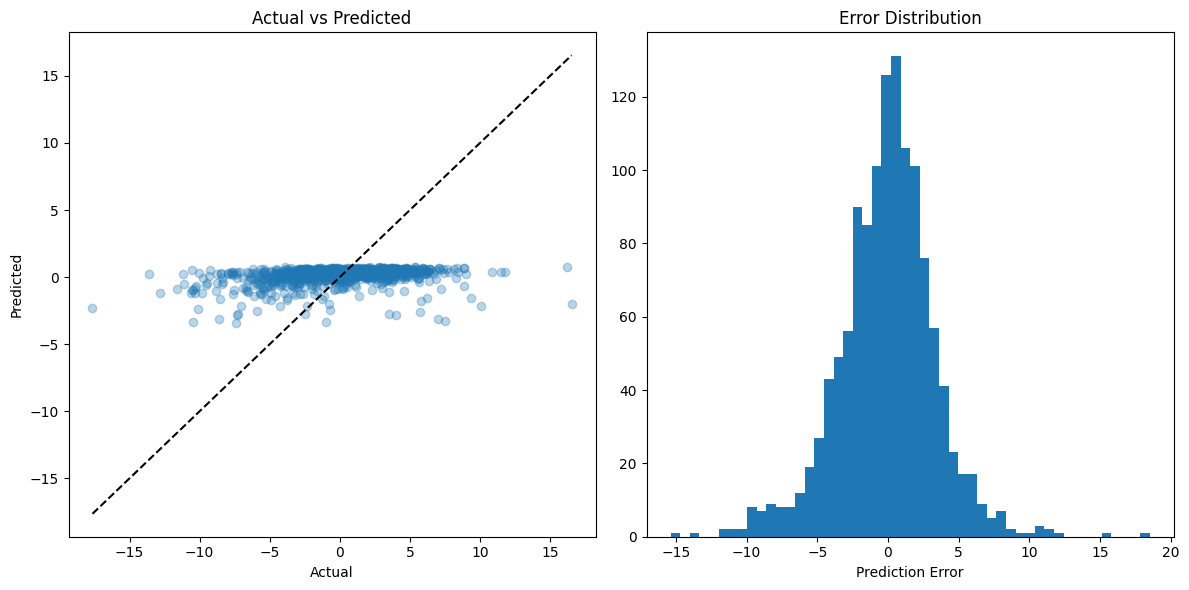

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, test_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

plt.subplot(1, 2, 2)
errors = y_test - test_pred.flatten()
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.title('Error Distribution')

plt.tight_layout()
plt.show()

In [26]:
mse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred.flatten()),
                         greater_is_better=False)

result = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    scoring=mse_scorer,
    random_state=42,
    n_jobs=-1
)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━

In [29]:
predictions = model.predict(X_test)

print(predictions[:5])
print(y_test[:5])

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
[[-3717502. ]
 [-2253986.5]
 [-2041145.8]
 [-2151587. ]
 [-1641841.2]]
5032   -4.885936
5033    0.713876
5034    0.917844
5035    0.547000
5036    0.064906
Name: day_diff, dtype: float64
